# Frequency Domain

## Core concepts

### Fourier Transform

FFT is a discrete Fourier transform algorithm which converts a signal from the **time domain** (signal strength as a function of time) to the **frequency domain** (signal strength as a function of frequency). Here's a [youtube video](https://www.youtube.com/watch?v=r18Gi8lSkfM&t=1s) that provides a nice visual representation of how it works.

- continuous and discretized equations
- example figure
- matlab


### Power spectrum

- definition
- formula
- and examples!!!!!!!!

Calculate on MATLAB as follows:
``` Octave
[ps,f_ps] = periodogram(Y,rectwin(N),N,Fs,'power');
```

### Power spectral density (PSD)

The power spectral density (PSD) shows where the average power (as it is a density) is distributed as a function of frequency, around one time window. It is expressed in `dB/Hz`.

- formula

Calculate on MATLAB as follows:
``` Octave
[psd,f_psd] = periodogram(Y,rectwin(N),N,Fs,'psd');
```

MATLAB also provides a [nice tutorial](https://www.mathworks.com/help/signal/ug/power-spectral-density-estimates-using-fft.html) for how to calculate both PSD and power spectra with and without the `periodogram()` function.

## Metrics


## Examples

The following section is dedicated to using MATLAB to develop an intuition for 1) how to calculate these metrics, and 2) how they are effected by changes in signal duration, frequency, amplitude among signal types.

### Simple example

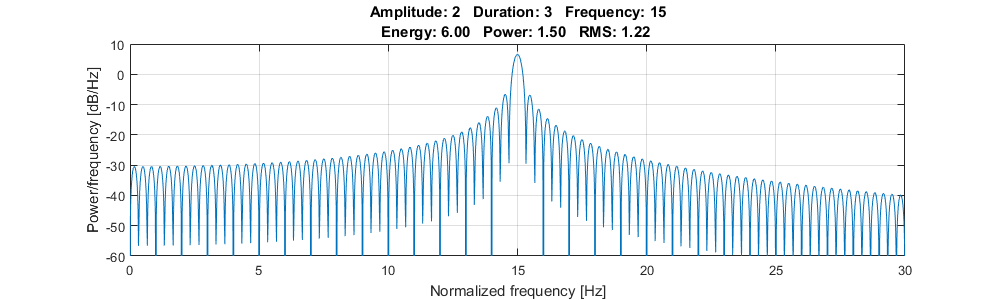

In [1]:
%plot -s 1000,300

%% signal parameters %%

% inputs
a = 2;          % signal amplitudes
f = 15;         % signal frequencies
d = 3;          % signal durations
D = 4;          % total duration
Fs = 1e3;       % sampling frequency

% calculated params
dt = 1/Fs;      % sample interval
n = Fs*d;       % length of signal (samples)
N = Fs*D;       % length of signal (samples)
NFFT = N*16;       % fft size
s0 = N/2-n/2;   % start of signal (samples)
t = 0:dt:d-dt;  % timesteps of signal
T = 0:dt:D-dt;  % timesteps of total

%% create signal %%

% uncomment one of the examples below

% create signal: white noise
% y = a/2*randn(1,n);

% create signal: sine wave
y = a*sin(2*pi*f*t);

% create signal: pulse
%y = a*gauspuls(t,f,0.5,-30);
    
% create signal: pulsetrain
%npls = 3; % number of pulses
%y_pulse = a*gauspuls(t,f,0.5,-30); % single pulse
%pls = y_pulse(1:floor(n/npls)); % crop single pulse
%pls = repmat(pls,1,npls); % repeat single pulse
%y = zeros(1,n); % allocate signal array
%y(1:length(pls)) = pls; % combine array

% create signal: chirp 
%y = chirp(t,f/2,d,f,'linear', -90);

% pad signal
pad = zeros(1,s0);
Y = [pad y pad];

% calculate power spectral density
[psd,f_psd] = periodogram(Y,rectwin(N),NFFT,Fs,'psd');

% calculate power
P = sum(psd)*Fs/NFFT;

% calculate energy
E = P*D;

% calculate RMS
RMS = sqrt(P);

% plot            
plot(f_psd,10*log10(psd)); grid on;
ylim([-60 10])
xlim([0 2*f])
ylabel('Power/frequency [dB/Hz]')
xlabel('Normalized frequency [Hz]')
title({sprintf('Amplitude: %1d   Duration: %1d   Frequency: %1d', a, d, f),...
                sprintf('Energy: %.02f   Power: %.02f   RMS: %.02f ', E, P, RMS)})  

### Advanced example

#### Common parameters

In [10]:
a = [1 2];      % signal amplitudes
f = [10 15];    % signal frequencies
d = [2 3];      % signal durations
D = 4;          % total duration
Fs = 1e3;       % sampling frequency

#### Plotting function

The following function will make it convenient for us to loop through all combinations of parameterizations, construct a given signal, calculate the metrics, and plot the output.

In [11]:
%%file plot_psd.m
function plot_psd(signal_type,a,f,d,Fs,D)

% parameters
dt = 1/Fs;      % sampling interval
N = Fs*D;       % length of total (samples)
NFFT = N*16;       % length of signal (samples)
T = 0:dt:D-dt;  % timesteps of total

figure
cnt=1;
for(ii = 1:length(a))
    a_i = a(ii); % amplitude
    for(jj = 1:length(f))
        f_i = f(jj); % frequency        
        for(kk = 1:length(d))
            d_i = d(kk); % duration
            
            % length of signal (samples)
            n = Fs*d_i;     
            
            % start of signal (samples)
            s0 = N/2-n/2;
            
            % timesteps of signal
            t = 0:dt:d_i-dt;
            
            % create pad
            pad = zeros(1,s0);
            
            % create signal
            switch lower(signal_type)                
                case 'noise'
                    y = a_i/2*randn(1,n);
                    f_i = NaN; % frequency doesn't apply here
                case 'sine'
                    y = a_i*sin(2*pi*f_i*t);
                case 'pulse'
                    y = a_i*gauspuls(t,f_i,0.5,-30);
                case 'pulsetrain'                    
                    
                    % create single pulse
                    y_pulse = a_i*gauspuls(t,f_i,0.5,-30);
                    
                    % number of pulses
                    npls = 3;

                    % crop single pulse
                    pls = y_pulse(1:floor(n/npls));

                    % repeat single pulse
                    pls = repmat(pls,1,npls);

                    % combine in zero-padded array
                    y = zeros(1,n);
                    y(1:length(pls)) = pls;
                
                case 'chirp'
                    y = chirp(t,f_i/2,d_i,f_i,'linear', -90);
            end

            % pad signal
            Y = [pad y pad];
            
            % power spectral density
            [psd,f_psd] = periodogram(Y,rectwin(N),NFFT,Fs, 'psd');
            
            % calculate power
            P = sum(psd)*Fs/NFFT;

            % calculate energy
            E = P*D;        
            
            % calculate RMS
            RMS = sqrt(P);
            
            % plot            
            subplot(length(a)*length(f)*length(d)/2,2,cnt)
            plot(f_psd,10*log10(psd)); grid on;
            ylim([-60 10])
            xlim([0 2*max(f)])
            ylabel('Power/frequency [dB/Hz]')
            xlabel('Normalized frequency [Hz]')
            title({sprintf('Amplitude: %1d   Duration: %1d   Frequency: %1d', a_i, d_i, f_i),...
                    sprintf('Energy: %.02f   Power: %.02f   RMS: %.02f ', E, P, RMS)}) 
            
            % update counter
            cnt=cnt+1;
        end
    end
end

set(gcf, 'PaperPosition', [0 0 20 24]); % increase figure size
return

Created file '/Users/hansenjohnson/Projects/intro-acoustics/docs/plot_psd.m'.


### White noise

In [12]:
cd /Users/hansenjohnson/Projects/intro-acoustics/docs

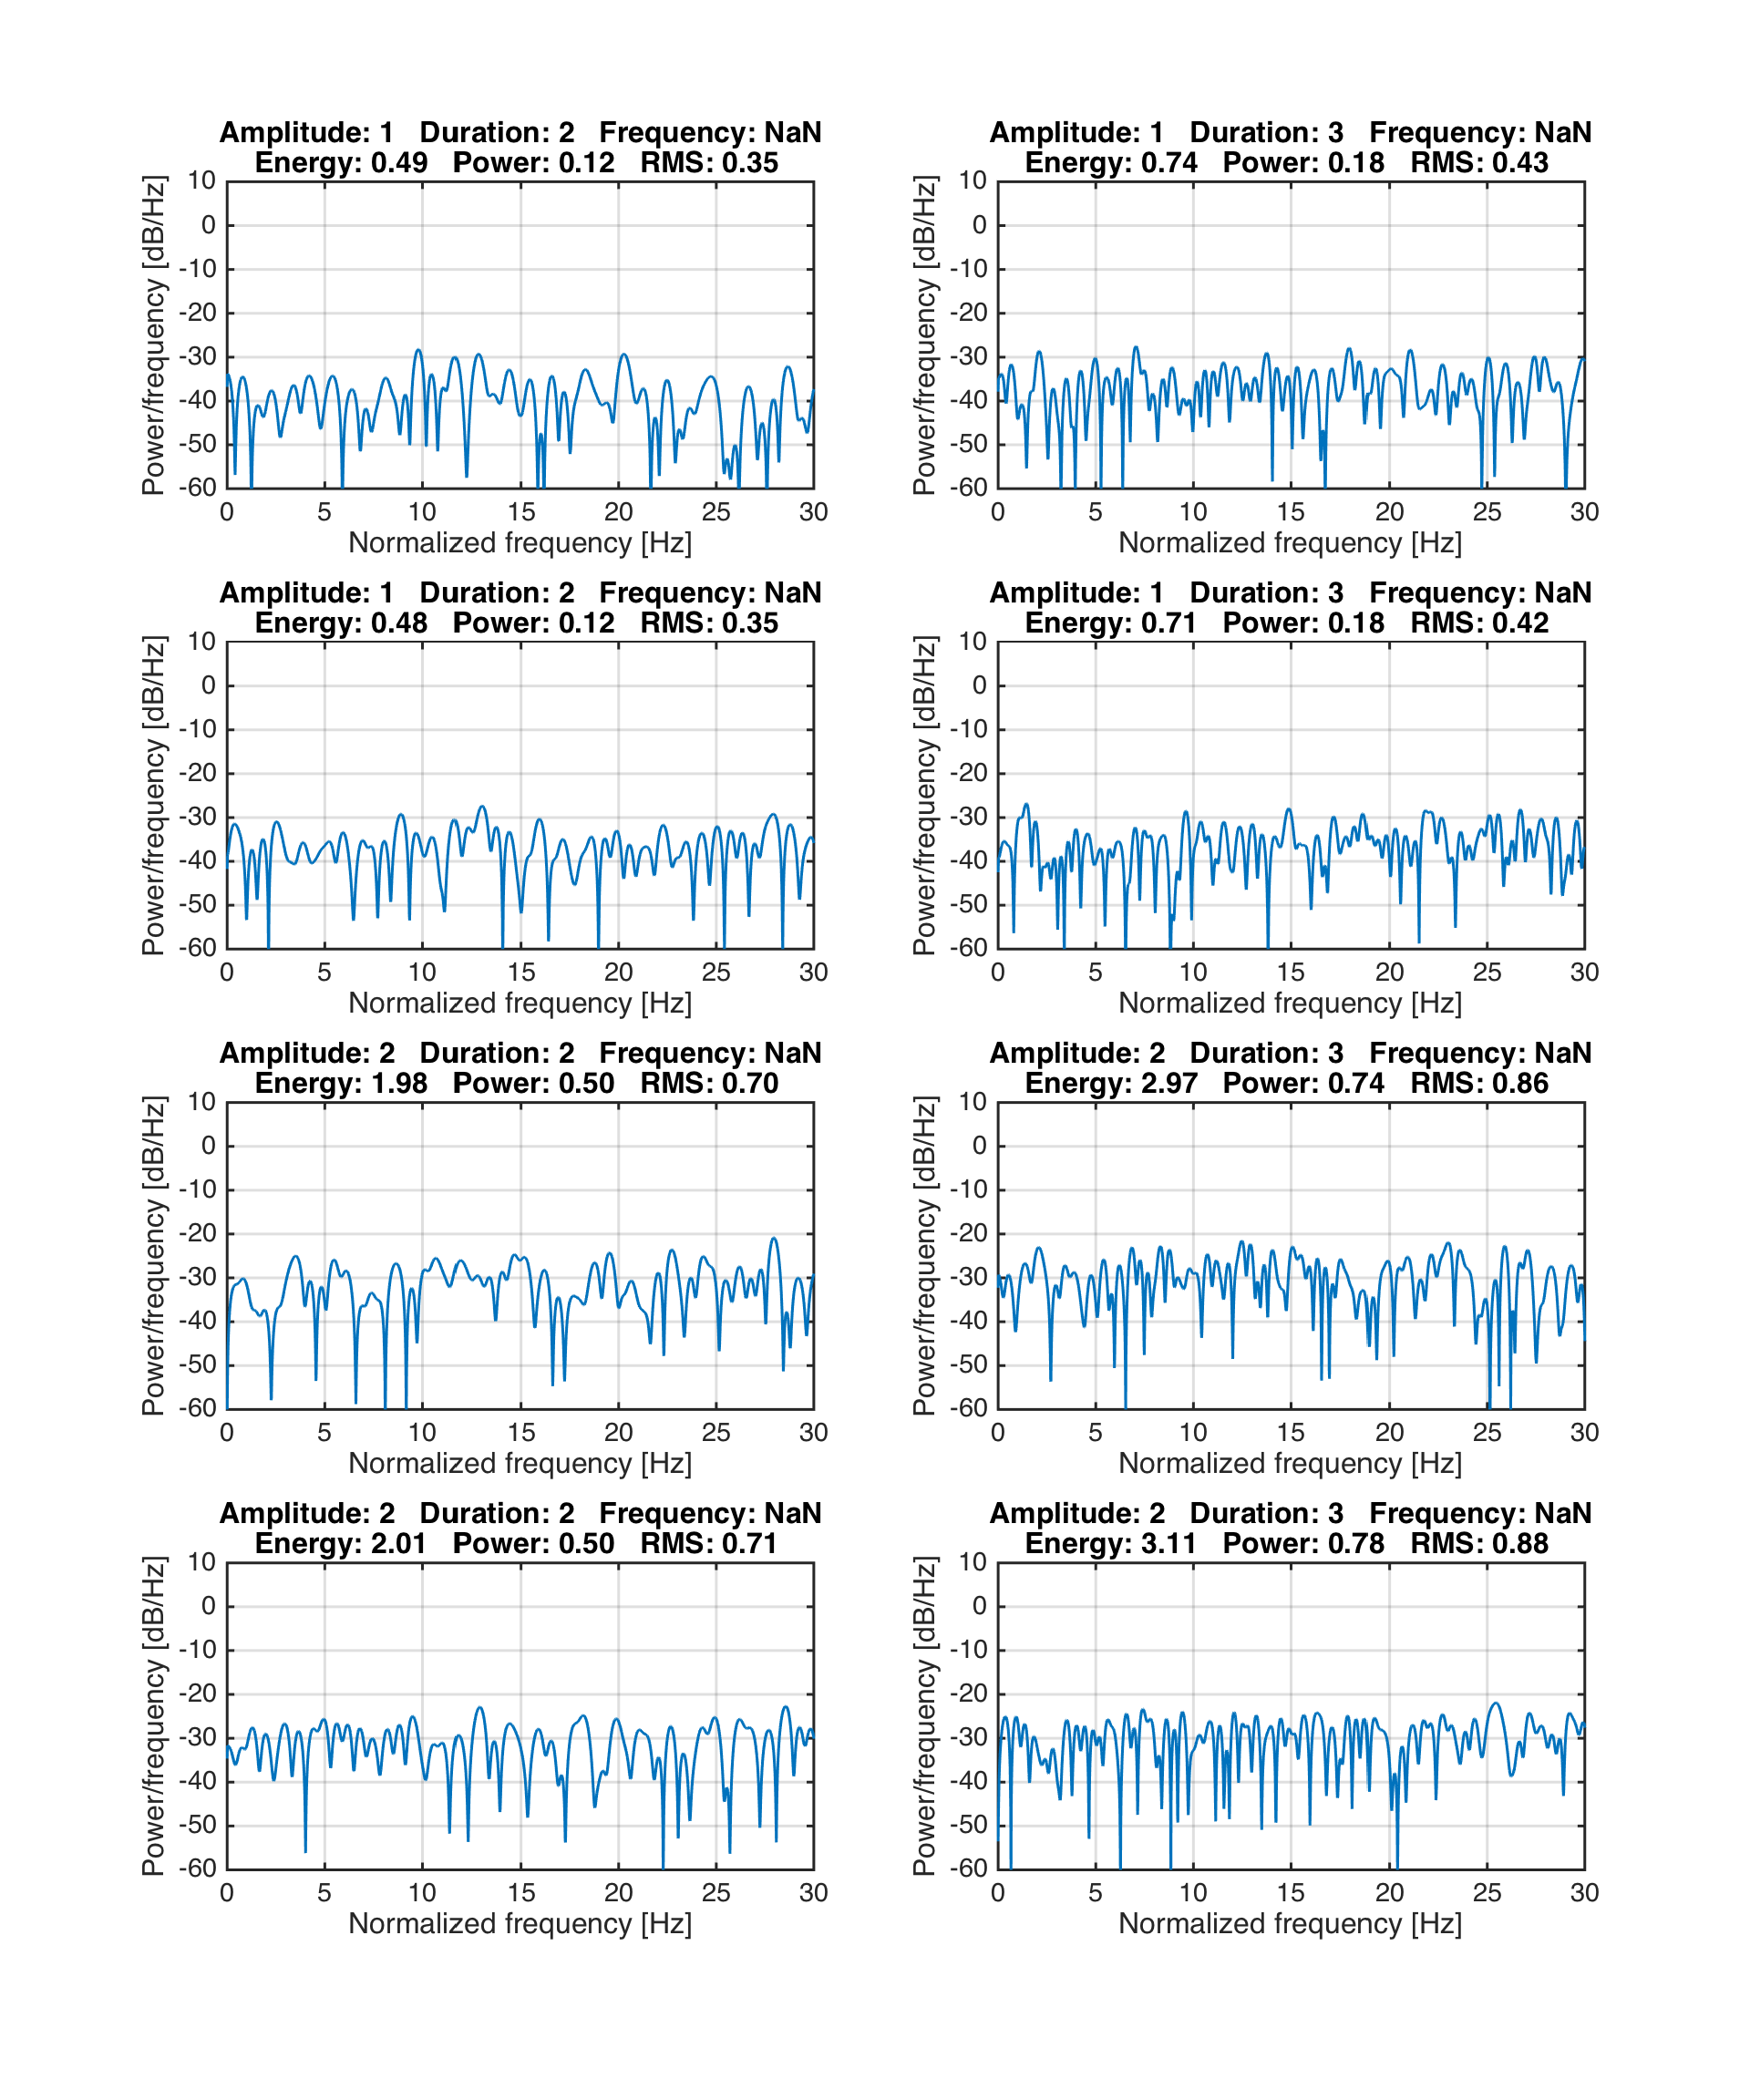

In [13]:
plot_psd('noise',a,f,d,Fs,D);

### Sine wave

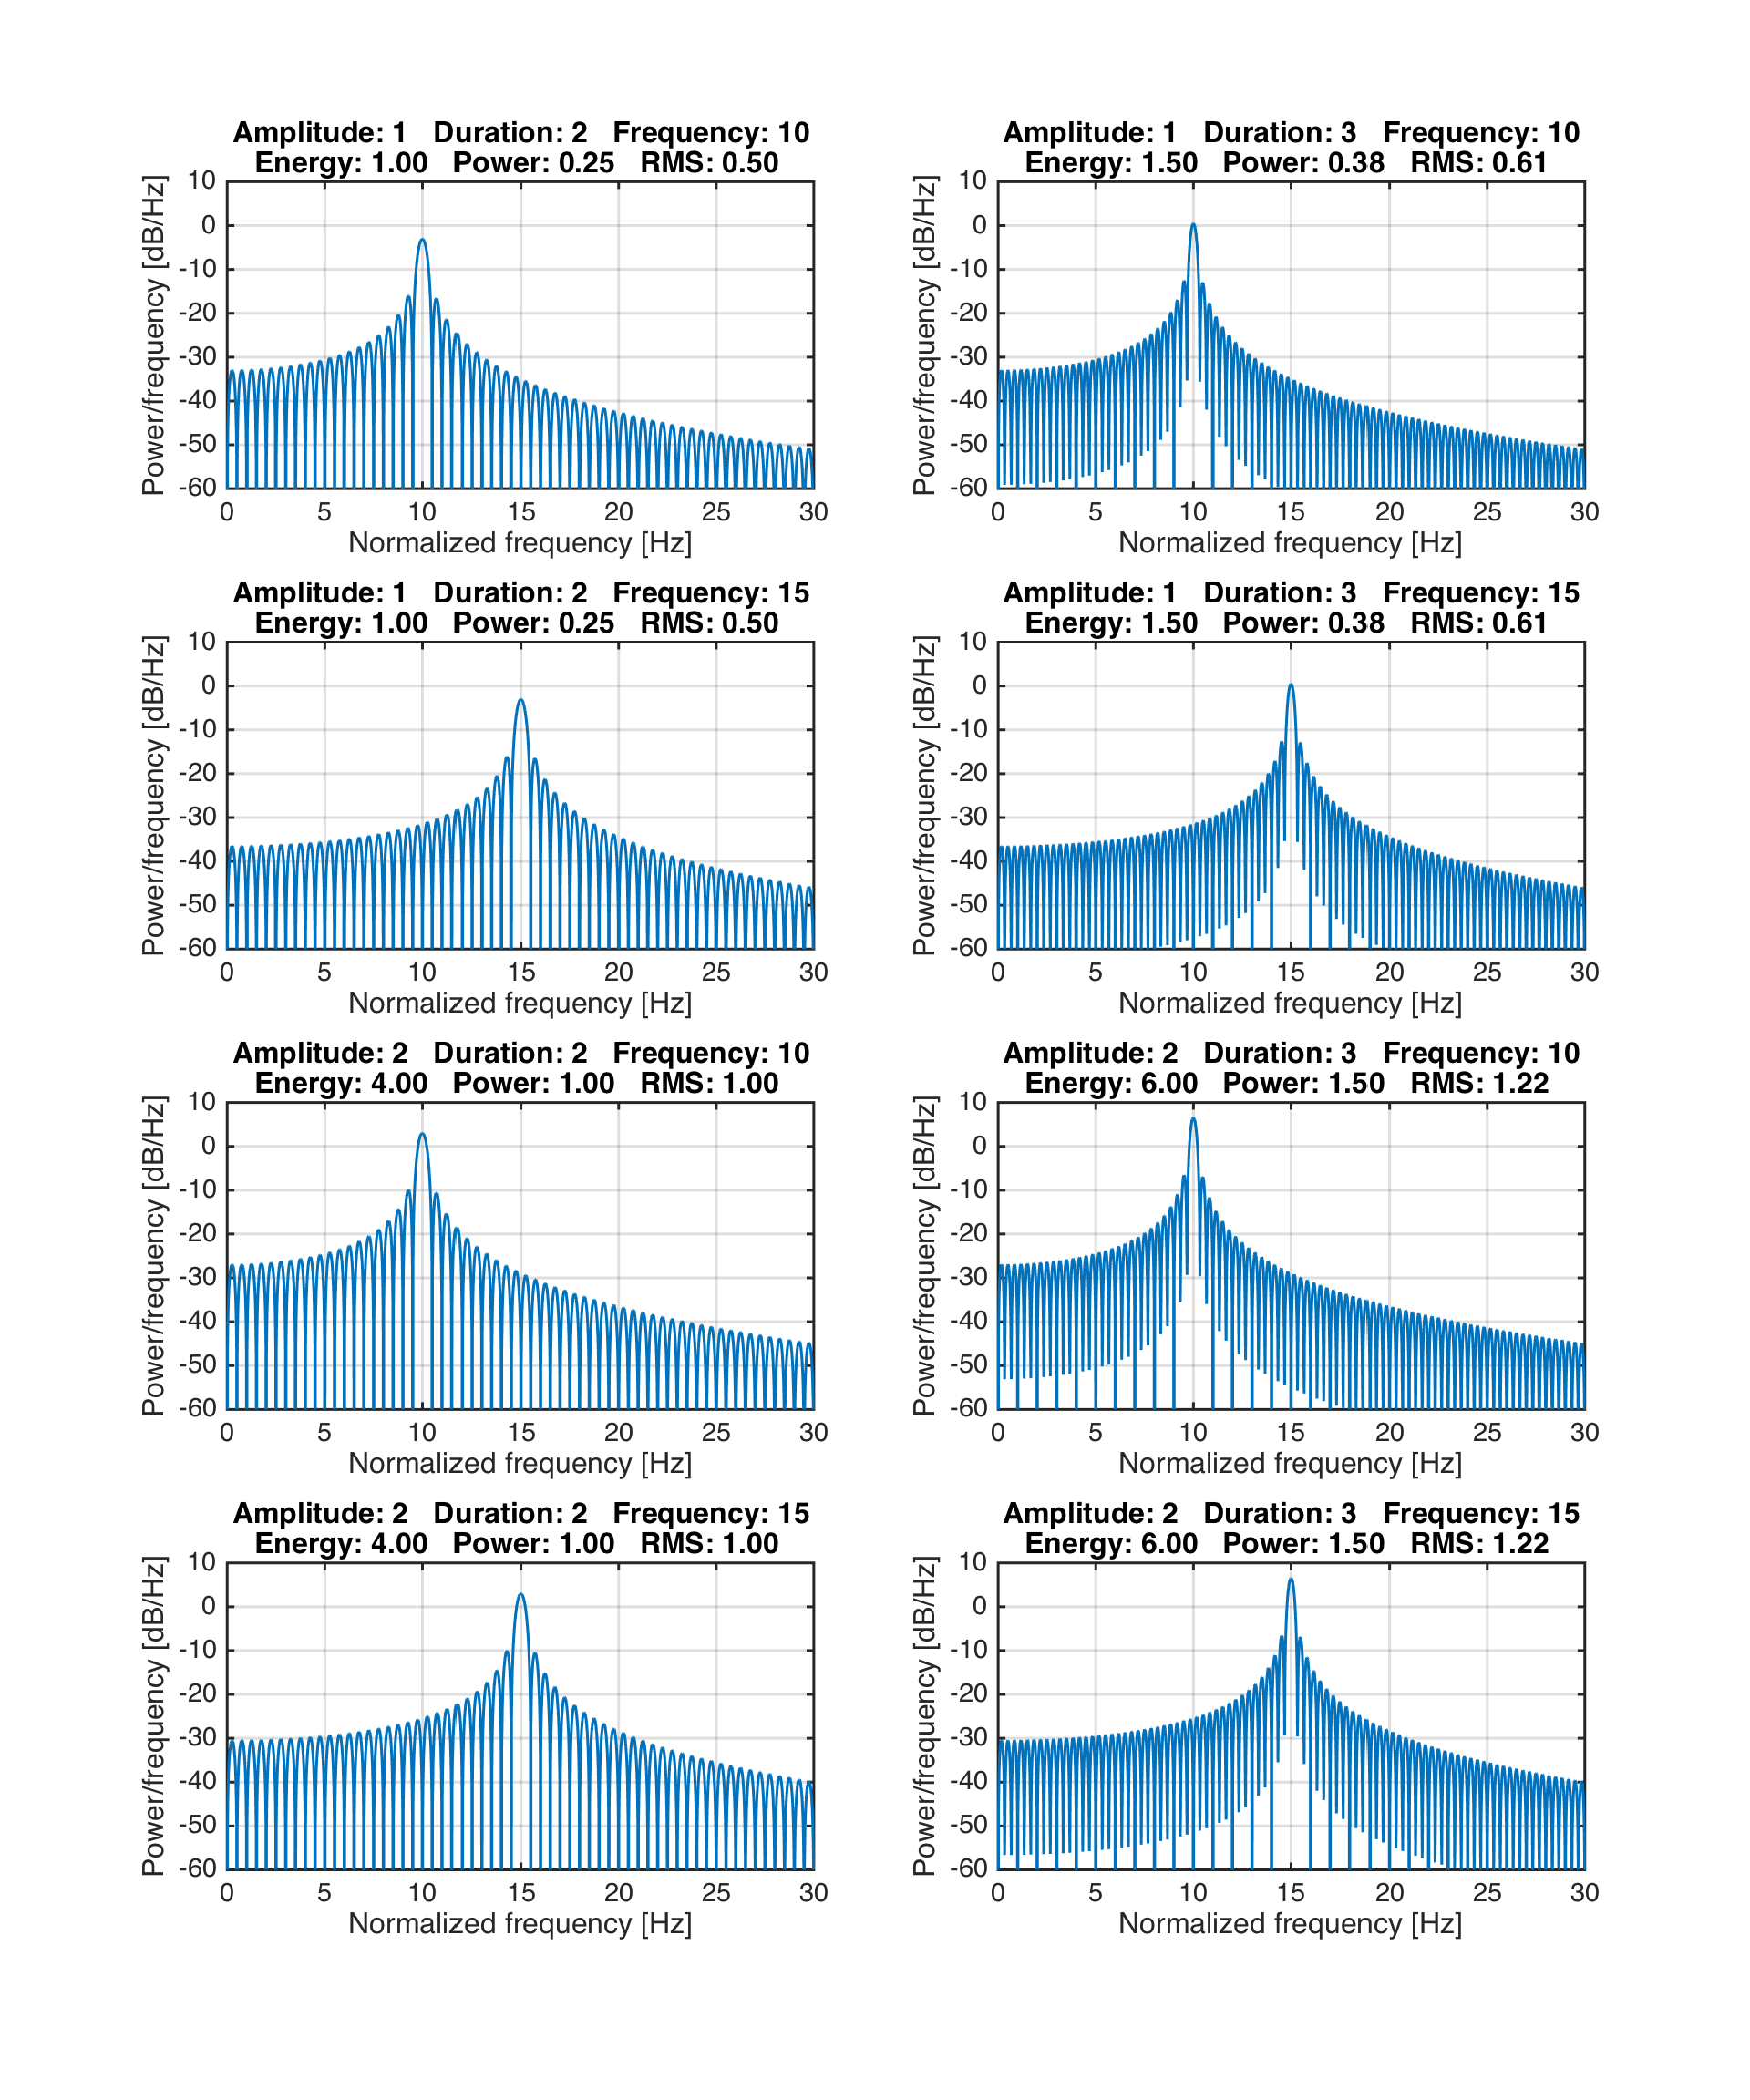

In [14]:
plot_psd('sine',a,f,d,Fs,D);

### Pulse

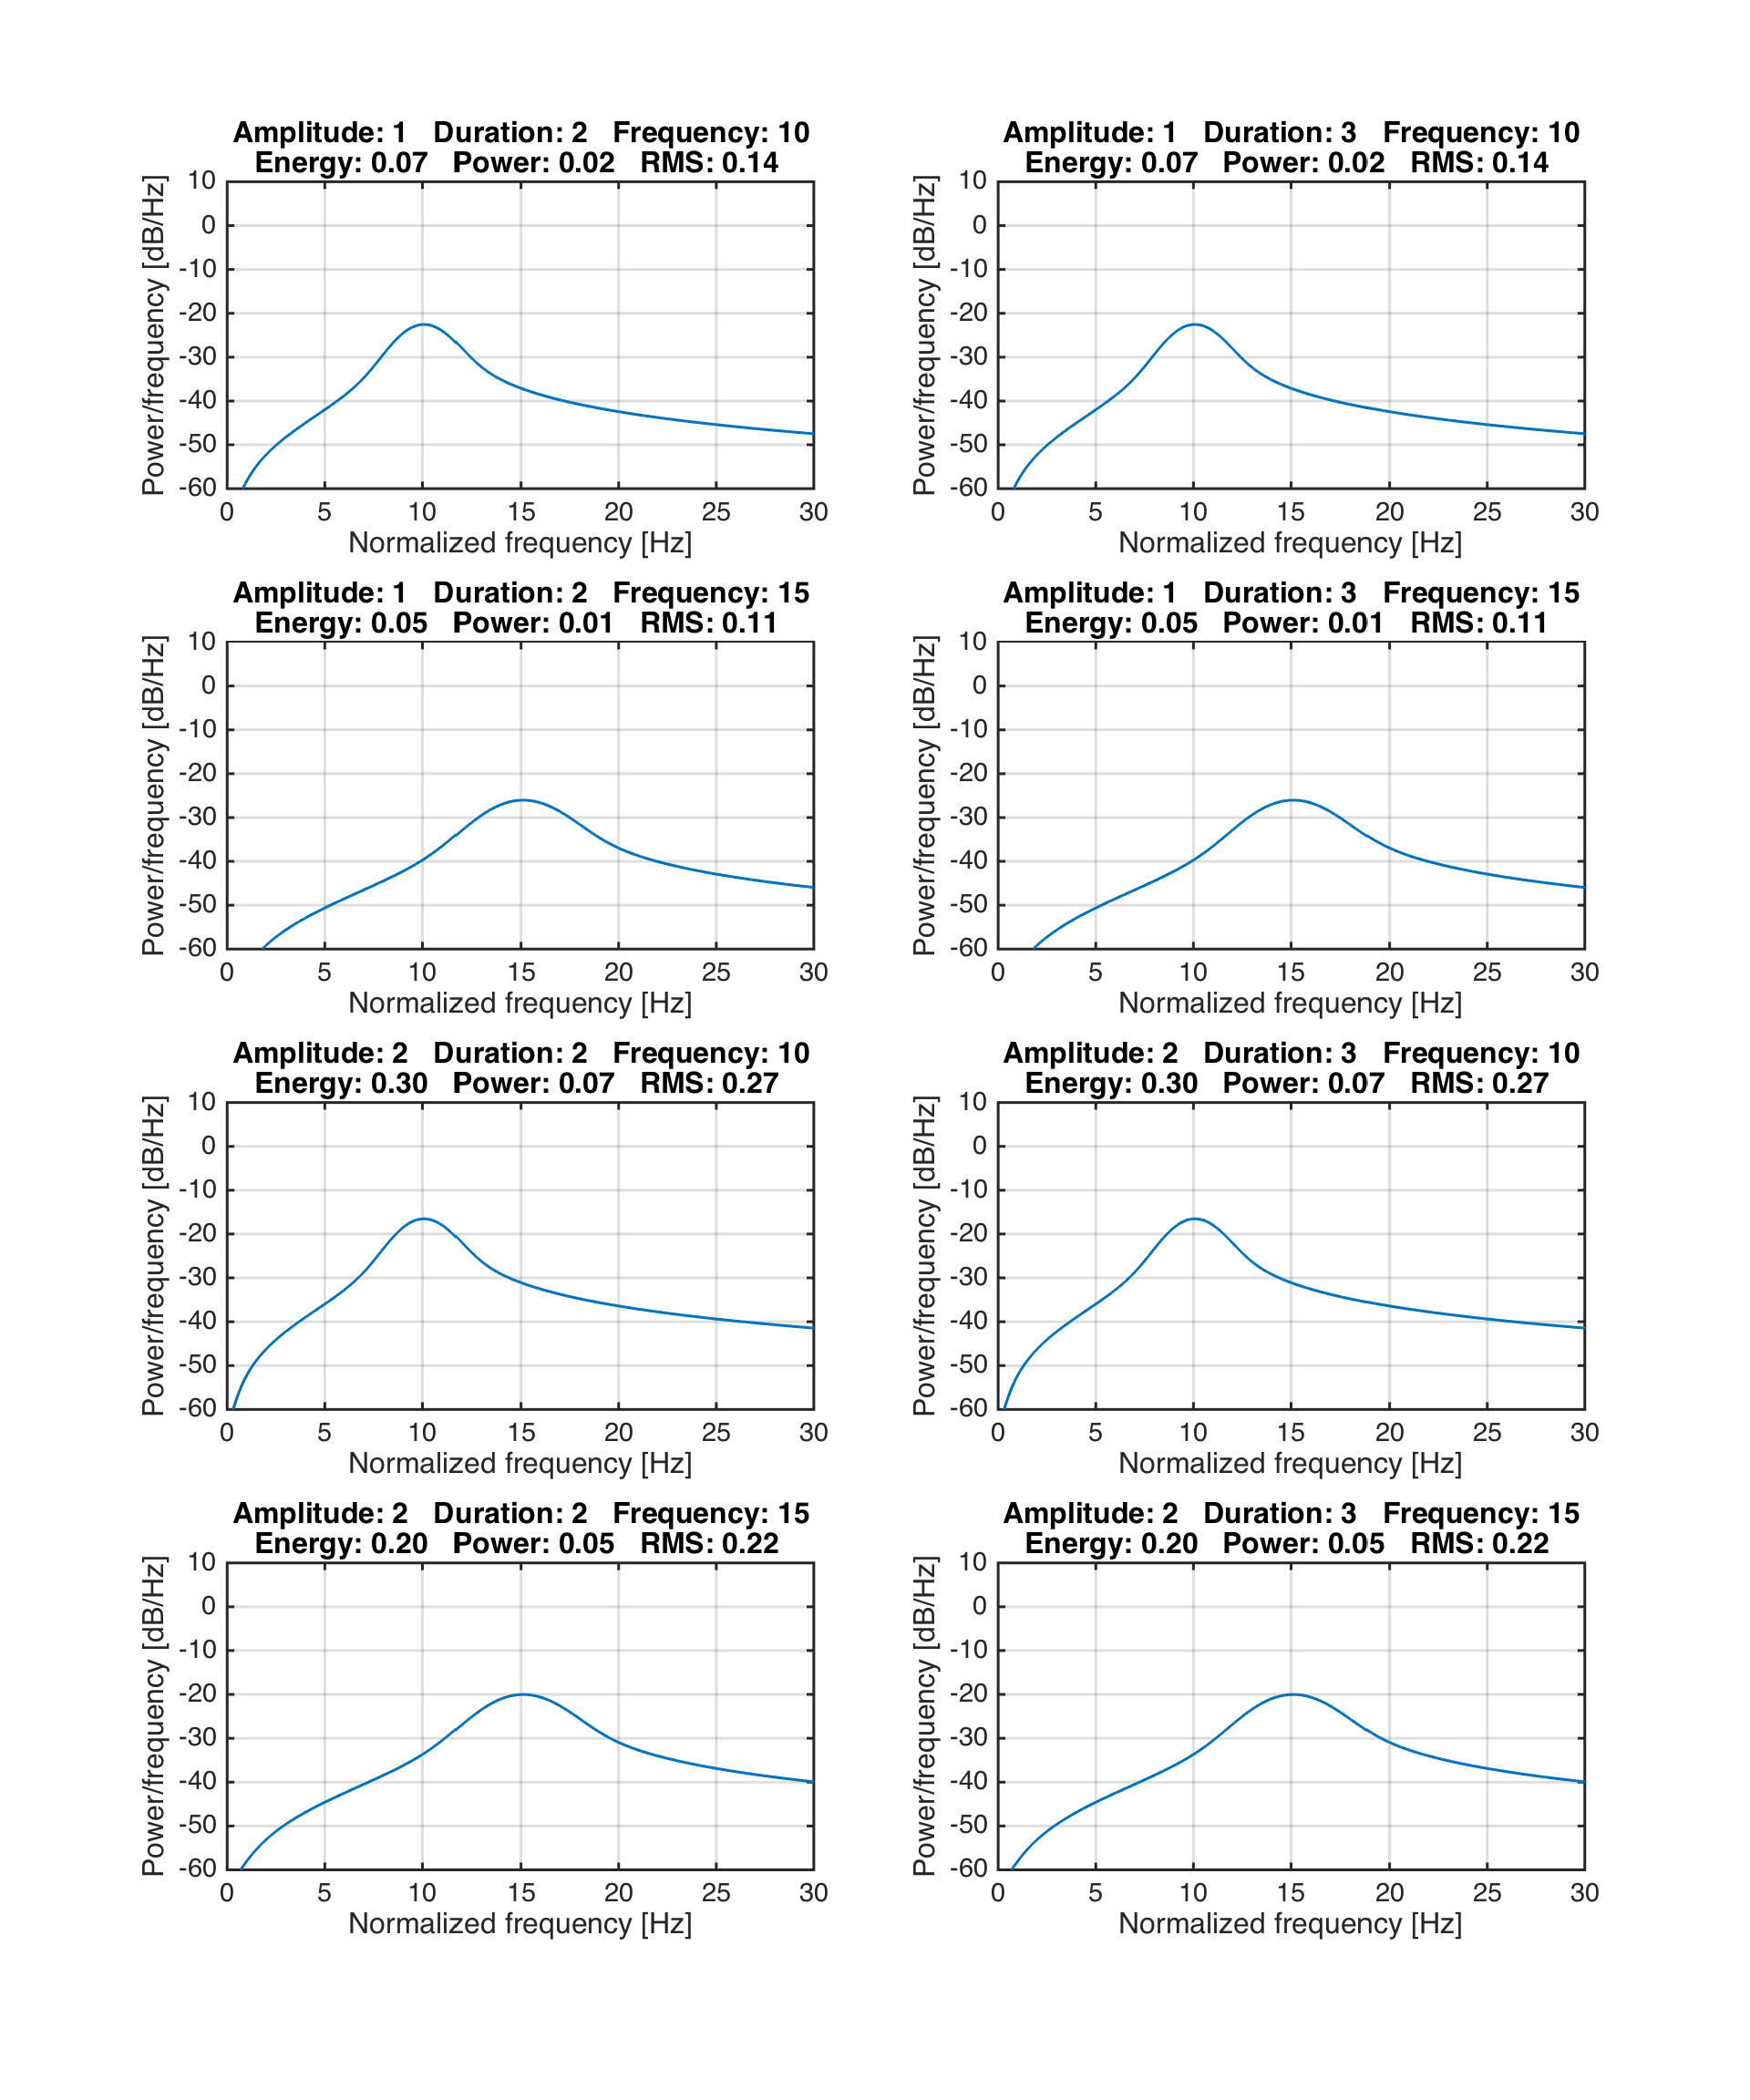

In [15]:
plot_psd('pulse',a,f,d,Fs,D);

### Pulse train

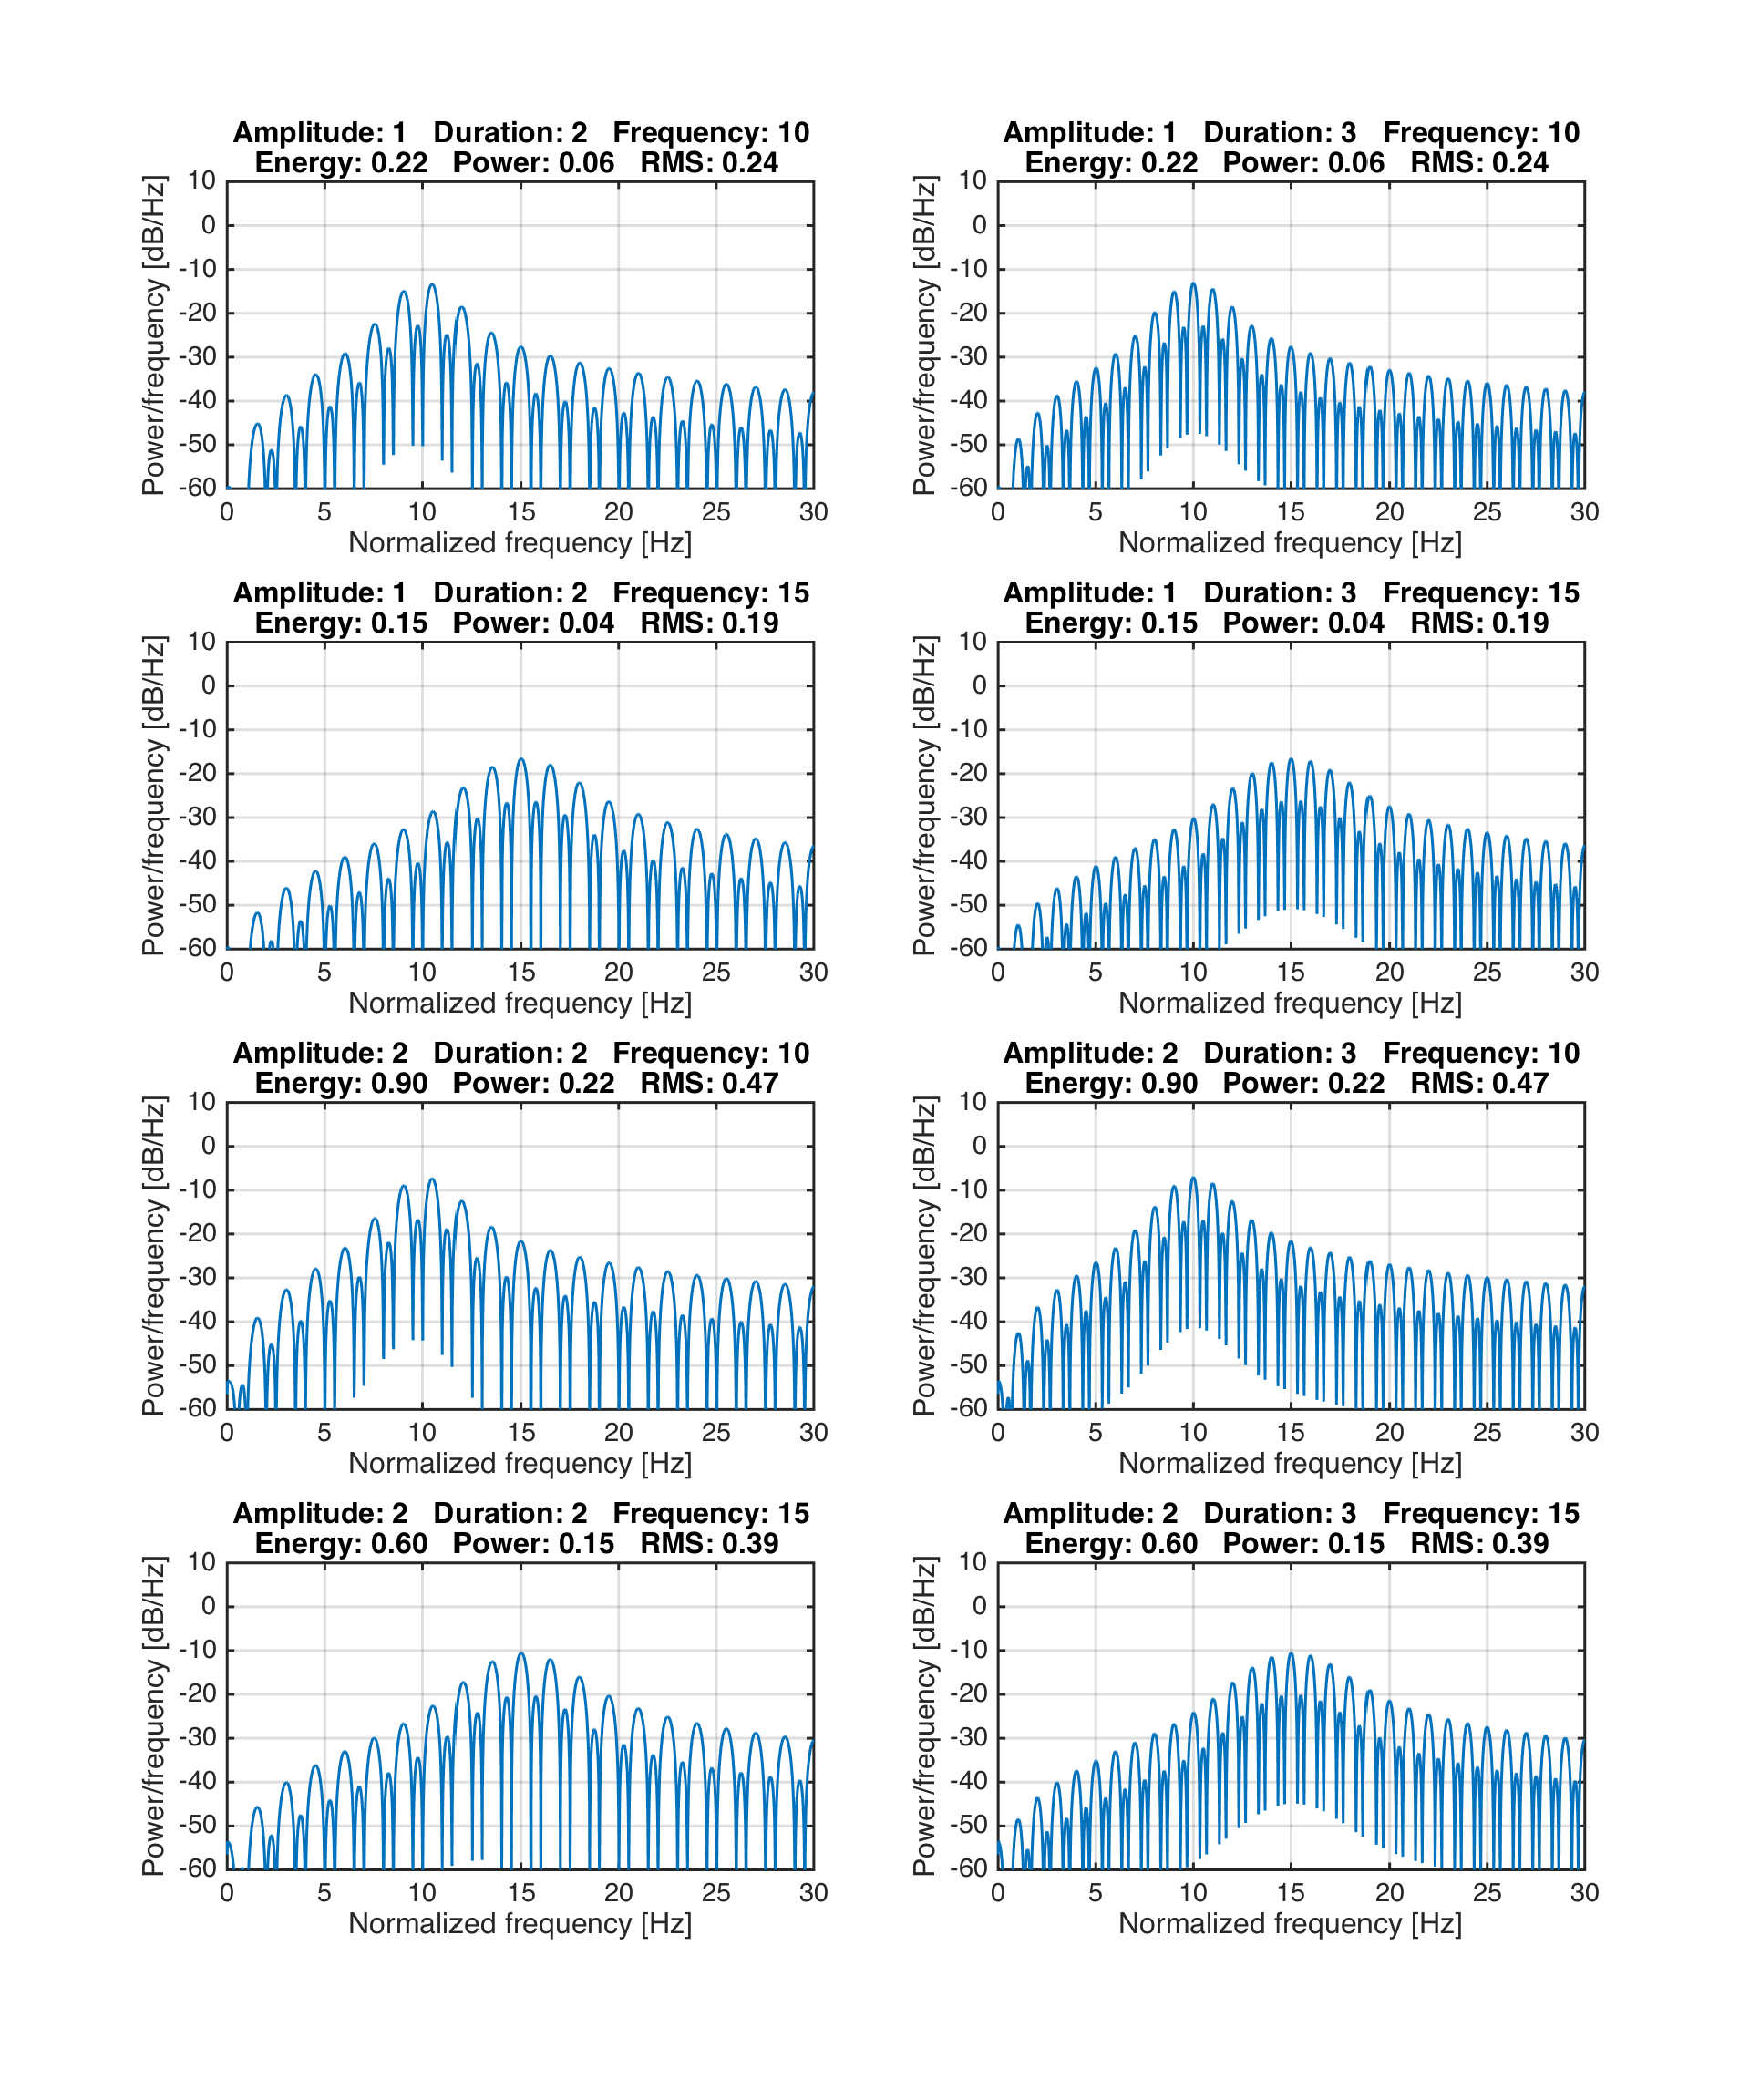

In [16]:
plot_psd('pulsetrain',a,f,d,Fs,D);

### Chirp

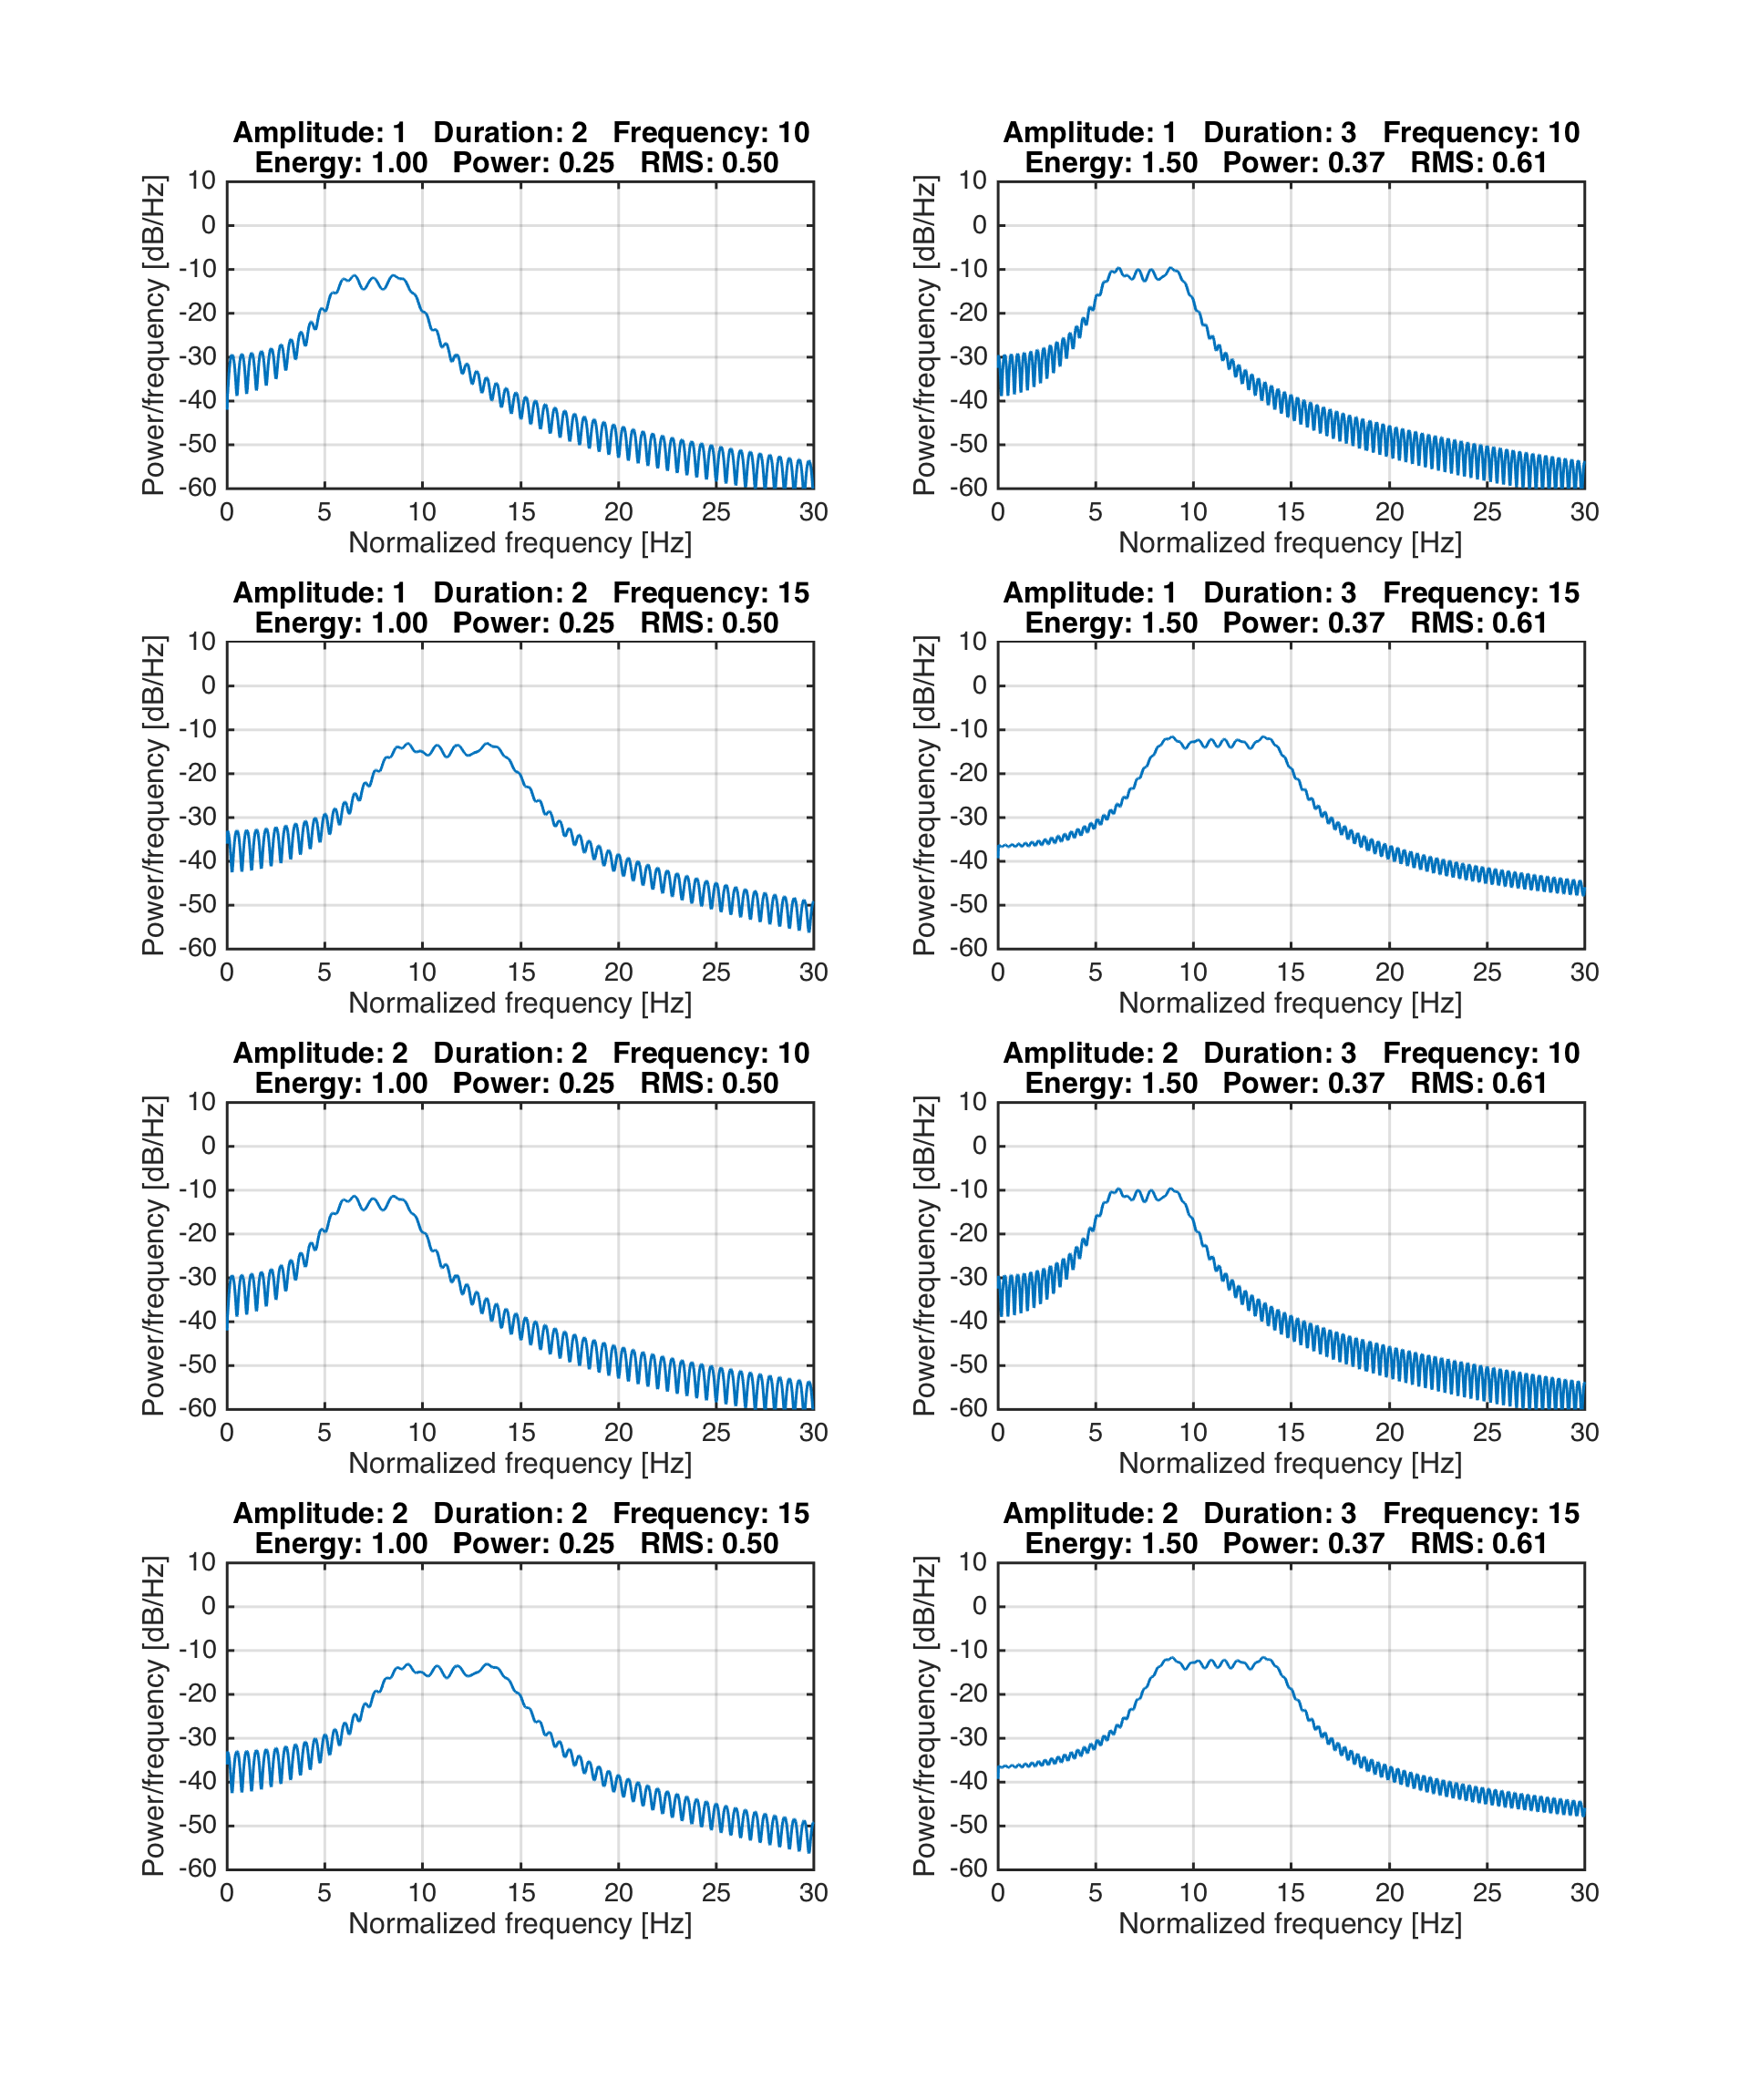

In [17]:
plot_psd('chirp',a,f,d,Fs,D);